Assignment 6B


1. Normal Convolution
2. Separable Convolution 
3. Depthwise Convolution
4. Grouped Convolution (use 3x3, 5x5 only)
5. Grouped Convolution (use 3x3 only, one with dilation = 1, and another with dilation = 2) 

Must use all of the 5 above at least once
Train this new model for 50 epochs. 

Implimenting DepthwiseConv2D in the model to do depthwise convolution as suggested. 

09-06-2019: 
On further evaluation based on comments on groups on telegram and rereading DepthwiseConv2D and SeparableConv2d; seems SeparableConv2d is the right choice for depthwise layer we are trying to impliment. replacing same and resubmitting


Importing al necessary keras, matplot, numpy libs

In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, SeparableConv2D, DepthwiseConv2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
#preparing check point for saving weights via callback
from google.colab import drive
from keras.callbacks import CSVLogger
from keras.callbacks import ModelCheckpoint

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


Importing, loading data in train and test

In [3]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 2s 0us/step


Viewsing train data for labels.

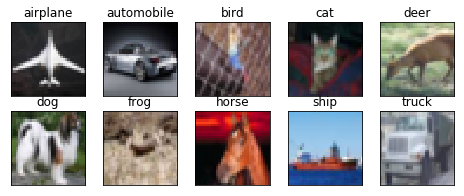

In [4]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

Defigning function to plot model training validation accuracy and loss

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

Defining function to find and return accracy of trained model in percentage

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

Normalizing train and test data 
Converting labels from 1-D to 2-D with leangth of second dimention is num_class

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

Defining Model and Compiling Model (converting model building form Sequential to Functional)

Changing model to including following 5 types of layers
1. Normal Convolution
2. Separable Convolution - https://www.programcreek.com/python/example/89684/keras.layers.SeparableConv2D
3. Depthwise Convolution
4. Grouped Convolution (use 3x3, 5x5 only)
5. Grouped Convolution (use 3x3 only, one with dilation = 1, and another with dilation = 2) 

Regerence:
1. https://github.com/changtimwu/changtimwu.github.com/issues/70
2. https://towardsdatascience.com/a-comprehensive-introduction-to-different-types-of-convolutions-in-deep-learning-669281e58215
3. https://machinelearningmastery.com/keras-functional-api-deep-learning/


In [0]:
#Defining model

#importing necessary modules
from keras.models import Model
from keras.layers import Input, Flatten, Conv2D
from keras.layers.merge import concatenate

# input layer
visible = Input(shape=(32,32,3))

# 1st Normal layer
conv1 = Conv2D(48, (3, 3), padding="same", activation='relu') (visible)

# 2nd Seperable layer
sep_conv31 = Conv2D(48, (3, 1), padding="same", activation='relu') (conv1)
sep_conv13 = Conv2D(48, (1, 3), padding="same", activation='relu') (sep_conv31)

#maxpooling
pool1 = MaxPooling2D(pool_size=(2, 2))(sep_conv13)

# 3rd Depthwise layer
# Replacing this implimentation with keras method DepthwiseConv2D
'''
dep_conv1 = Conv2D(1, (3, 3), padding="same", activation='relu') (pool1)
dep_conv2 = Conv2D(96, (1, 1), padding="same", activation='relu') (dep_conv1)
'''
#dep_conv2 = DepthwiseConv2D((3, 3), padding="same", depth_multiplier=1, strides=(1,1), use_bias=False) (pool1)

'''09-06-2019: On further evaluation based on comments on groups on telegram and rereading DepthwiseConv2D and SeparableConv2d;
seems SeparableConv2d is the right choice for depthwise layer we are trying to impliment. replacing same and resubmitting'''
dep_conv2 = SeparableConv2D(96, (3, 3), padding="same", depth_multiplier=1, strides=(1,1), use_bias=False) (pool1)

#maxpooling
pool2 = MaxPooling2D(pool_size=(2, 2))(dep_conv2)

#4th Grouped Convolution (use 3x3, 5x5 only)
# first feature extractor
grp_conv1 = Conv2D(96, (3, 3), padding="same", activation='relu')(pool2)
# second feature extractor
grp_conv2 = Conv2D(96, (3, 3), padding="same", activation='relu')(pool2)
# merge feature extractors
grp_merge = concatenate([grp_conv1, grp_conv2])

#5th Grouped Convolution (use 3x3 only, one with dilation = 1, and another with dilation = 2)
# first feature extractor
grp_dl1_conv1 = Conv2D(96, (3, 3), padding="same", dilation_rate=(1, 1), activation='relu')(grp_merge)
# second feature extractor
grp_dl2_conv2 = Conv2D(96, (3, 3), padding="same", dilation_rate=(2, 2), activation='relu')(grp_merge)
# merge feature extractors
grp_dl_merge = concatenate([grp_dl1_conv1, grp_dl2_conv2])

#
flat = Flatten()(grp_dl_merge)
hidden1 = Dense(10, activation='relu')(flat)
output = Dense(10, activation='softmax')(hidden1)
model = Model(inputs=visible, outputs=output)

In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 32, 32, 48)   1344        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 32, 32, 48)   6960        conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 32, 32, 48)   6960        conv2d_5[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [0]:

#Adding lr rate scheduling and model saving
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
def scheduler(epoch, lr):
  return round(0.01 * 1/(1 + 0.319 * epoch), 10)

filepath="/content/gdrive/My Drive/Weights/Assignment6B_v1_final_weights-improvement-{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

callback_list = [LearningRateScheduler(scheduler, verbose=1), checkpoint]

# Compile the model
model.compile(optimizer=Adam(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])


Training for Epochs = 100 and comparing with Base accuracy is 82.73 
Reducing training epochs to 50

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=390, epochs=50)`
  del sys.path[0]


Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.01.
390/390 [==============================] - 16s 40ms/step - loss: 2.3111 - acc: 0.0967 - val_loss: 2.3034 - val_acc: 0.1000

Epoch 00001: val_acc improved from -inf to 0.10000, saving model to /content/gdrive/My Drive/Weights/Assignment6B_v1_final_weights-improvement-01-0.1000.hdf5
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.0075815011.
390/390 [==============================] - 9s 23ms/step - loss: 2.3032 - acc: 0.0999 - val_loss: 2.3027 - val_acc: 0.1000

Epoch 00002: val_acc did not improve from 0.10000
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.0061050061.
390/390 [==============================] - 9s 23ms/step - loss: 2.3031 - acc: 0.0973 - val_loss: 2.3027 - val_acc: 0.1000

Epoch 00003: val_acc did not improve from 0.10000
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 0.005109862.
390/390 [============================

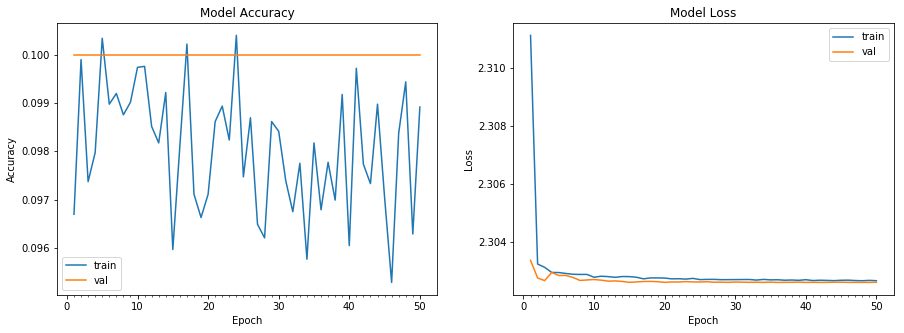

Accuracy on test data is: 10.00


In [12]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1, 
                                 callbacks=callback_list)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))